In [1]:
import sys
import os
sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [3]:
cfg.data.sdoml.sub_directory.eve

'EVE_legacy.zarr"'

In [4]:
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 16,
    num_workers = 6,
    num_frames  = 1,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2010-01-01',
    end_date   = '2010-12-31',
    dim = True,
    sampling_period = '5days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(12, 64, 5, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 5, stride=2)
        self.conv3 = nn.Conv2d(128, 32, 5, stride=2)
        self.fc1 = nn.Linear(1568, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
    
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(3,)
        self.pool2 = nn.AvgPool2d(2,)

        self.conv1 = nn.Conv2d(12, 64, 3, stride=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1)
        self.fc1 = nn.Linear(93312, 12)

    def forward(self, x):
        x = self.pool2(x) # downscale img by 2 (to make it similar to paper)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

In [6]:
model = Net1()

In [7]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
val_iter = iter(dlval)
len(dltrain), len(dlval)

(929, 158)

In [8]:
psize = [np.prod(i.shape) for i in model.parameters()]
print (psize, sum(psize))


[19200, 64, 204800, 128, 102400, 32, 188160, 120, 10080, 84, 1008, 12] 526088


In [9]:
model = Net1().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
#loss_fn = lambda a,b: torch.mean((a-b)**2 )

In [ ]:
et = ElapsedTimes()
num_epochs = 100
lossh, lossvalh = [], []
for epoch in range(num_epochs):
    t0 = datetime.now() 

    for step, batch in enumerate(dltrain):
        # extract data from batch
        with et("batch"):
            x = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
            f = batch['dim_factor'].type(torch.float).cuda()

        # run model
        with et("forward"):
            o = model(x)

        # compute loss
        with et("loss"):
            loss = loss_fn(f,o)

        # backpropage and sigmoidupdate
        with et("backward"):
            loss.backward()
            optimizer.step()

        with et("validation"):

            # measure on val every 10 steps
            if step%10 == 0:
                try:
                    val_batch = next(val_iter)        
                except Exception as e:
                    val_iter = iter(dlval)                
                    val_batch = next(val_iter)        

                xval = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
                fval = batch['dim_factor'].type(torch.float).cuda()
                with torch.no_grad():
                    oval = model(x)
                    lossval = loss_fn(f,o)

                    lossvaln = lossval.detach().cpu().numpy()

        with et("logging"):
            # cosmetics
            lossn = loss.detach().cpu().numpy()
            lossh.append(lossn)

            lossvalh.append(lossvaln)


            psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
            lossm = np.mean(lossh[-100:])
            lossvalm = np.mean(lossvalh[-100:])
            epoch_time = (datetime.now() - t0).seconds
            print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")

    print()

epoch   0 step 928 loss 0.24618 lossval 0.25290 params 0.0281104 epoch_time 508 secs


In [11]:
et

{'batch': 586.1441578865051, 'forward': 8.1301748752594, 'loss': 1.0517053604125977, 'backward': 19.454721450805664, 'validation': 125.91151571273804, 'logging': 285.20070695877075}

In [12]:
sum(list(et.elapsed_times.values()))

1025.8929822444916

In [13]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)

(0.0, 0.1)

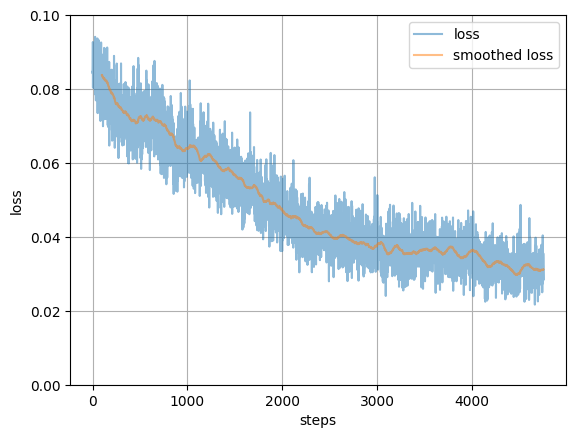

In [15]:
ploth(lossh)
plt.ylim(0,.1)